In [1]:
from spacepy import pycdf
from scipy.io import readsav
import numpy
import struct
import datetime
from pathlib import Path
from matplotlib import pyplot as plt
import subprocess
%matplotlib inline

In [2]:
_DATA_DIR = Path('../data/')

In [3]:
ephm = readsav(str(_DATA_DIR / 'jupeph.sav'))
meta = readsav(str(_DATA_DIR / 'Jup_2000_1.sav'))

with open(str(_DATA_DIR / 'Jup_2000_1.flux'), 'rb') as fd:
    buffer = fd.read()
    ndata = 174720*206
    read_format = '>'+str(ndata)+'f'
    read_size = struct.calcsize(read_format)
    data = numpy.array(struct.unpack(read_format, buffer)).reshape(174720, 206)
    

In [4]:
# note on time: meta['t'] is given in days of year 2000, so Jan. 1st, 2000 corresponds to meta['t']=1
tt = numpy.array([datetime.datetime(2000, 1, 1) + datetime.timedelta(days=(dt-1)) for dt in meta['t']])
ant_mode = numpy.array([item.decode('ascii') for item in meta['m']] )

Text(0.5, 1.0, 'Calibrated Flux density measured by Cassini/RPWS/HFR\non 2000-10-01T00:00:00 from a distance of 1184.96 Rj')

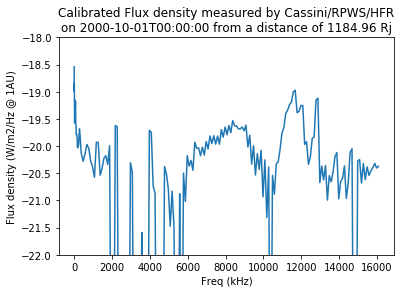

In [5]:
# plotting the first spectrum
plt.plot(meta['f'], data[0]) 
plt.ylim((-22,-18))
plt.xlabel('Freq (kHz)')
plt.ylabel('Flux density (W/m2/Hz @ 1AU)')
plt.title('Calibrated Flux density measured by Cassini/RPWS/HFR\non {} from a distance of {:6.2f} Rj'
          .format(tt[0].isoformat(), meta['r'][0]))

Text(0.5, 1.0, 'Calibrated Flux density measured by Cassini/RPWS/HFR\non 2001-01-02T18:00:00 from a distance of 144.00 Rj')

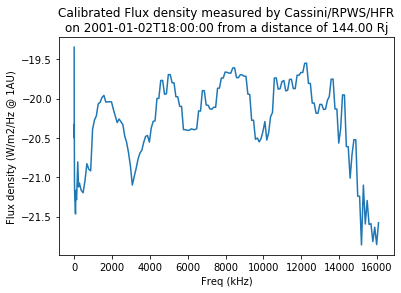

In [6]:
# plotting the 90000th spectrum
i=90000
plt.plot(meta['f'], data[i]) 
plt.xlabel('Freq (kHz)')
plt.ylabel('Flux density (W/m2/Hz @ 1AU)')
plt.title('Calibrated Flux density measured by Cassini/RPWS/HFR\non {} from a distance of {:6.2f} Rj'
          .format(tt[i].isoformat(), meta['r'][i]))

In [7]:
print("List of Antenna modes: {}".format(', '.join([item.decode('ascii') for item in numpy.unique(meta['m'])])))
print('- 1: single monopole mode')
print('- D: dipole mode')
print('- M: monopole switching mode')

List of Antenna modes: 1, D, M
- 1: single monopole mode
- D: dipole mode
- M: monopole switching mode


(9675, 206)
(9675,)


Text(0.5, 0, 'date')

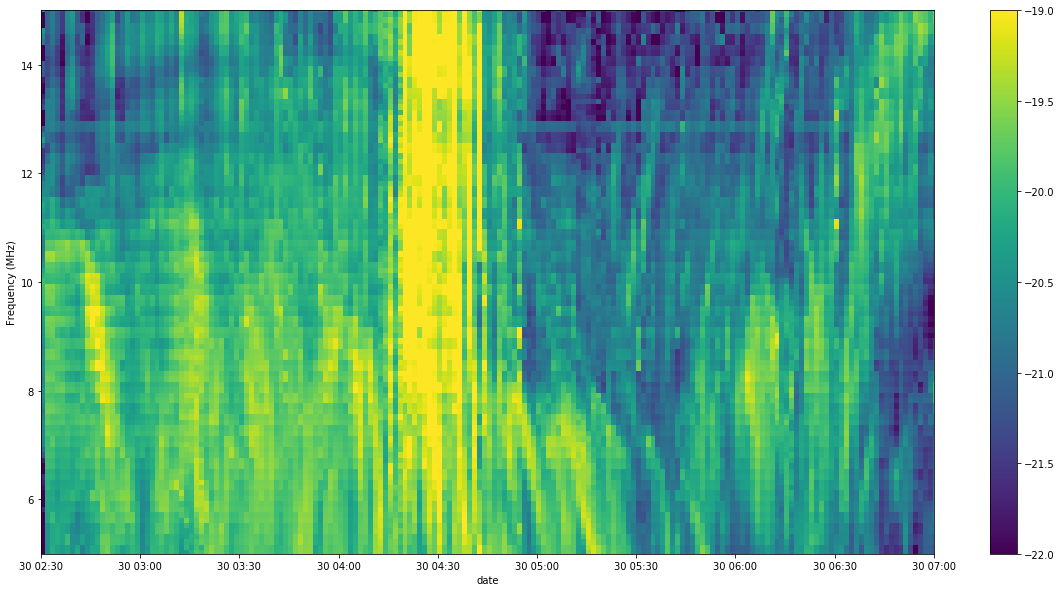

In [8]:
# plotting data in dipole mode:
data_d = data[ant_mode == 'D',:]
print(data_d.shape)
tt_d = tt[ant_mode == 'D']
print(tt_d.shape)
plt.figure(figsize=(20,10))
plt.pcolormesh(tt_d, meta['f']/1000, data_d.transpose(), vmin=-22, vmax=-19)
plt.colorbar()
plt.ylim((5,15))
plt.xlim((datetime.datetime(2000, 12, 30, 2, 30), datetime.datetime(2000, 12, 30, 7, 0)))
plt.ylabel('Frequency (MHz)')
plt.xlabel('date')

(154712, 206)
(154712,)


Text(0.5, 0, 'date')

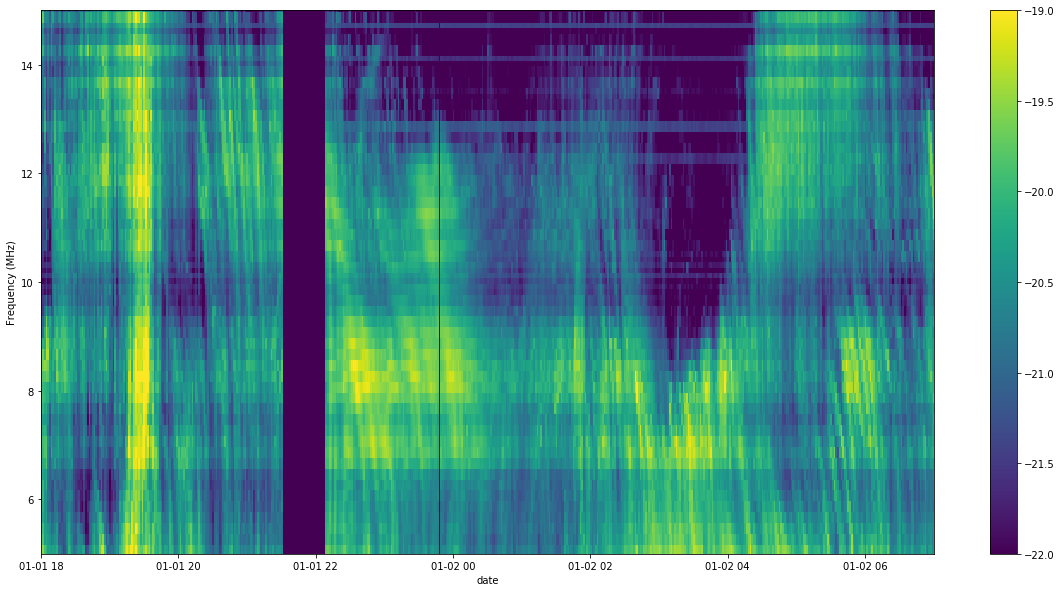

In [9]:
# plotting data in Monopole mode:
data_d = data[ant_mode == 'M',:]
print(data_d.shape)
tt_d = tt[ant_mode == 'M']
print(tt_d.shape)
plt.figure(figsize=(20,10))
plt.pcolormesh(tt_d,meta['f']/1000,data_d.transpose(), vmin=-22, vmax=-19)
plt.colorbar()
plt.ylim((5,15))
plt.xlim((datetime.datetime(2001, 1, 1, 18, 0), datetime.datetime(2001, 1, 2, 7, 0)))

plt.ylabel('Frequency (MHz)')
plt.xlabel('date')

In [10]:
# creating CDF file for distribution, compliant with PDS archive standards
# PDS-CDF documentation: https://pds-ppi.igpp.ucla.edu/doc/cdf/

file_cdf = _DATA_DIR / 'co_rpws_hfr_jupiter_cal_flux_20001001_20010331_v10.cdf'
if file_cdf.exists():
    file_cdf.unlink()

pycdf.lib.set_backward(False)  # this is setting the CDF version to be used
    
with pycdf.CDF(str(file_cdf), '') as cdf:
    cdf.col_major(True)  # Column Major
    cdf.compress(pycdf.const.NO_COMPRESSION)  # No file level compression
    
    cdf.attrs["Project"] = ["PADC>Paris Astronomical Data Centre"]
    cdf.attrs['Discipline'] = "Planetary Physics>Waves"
    cdf.attrs['Data_type'] = 'HFR_JUPITER_CAL_FLUX'
    cdf.attrs['Descriptor'] = 'RPWS'
    cdf.attrs['Data_version'] = '10'
    cdf.attrs['Instrument_type'] = 'Radio and Plasma Waves (space)'
    cdf.attrs['Logical_file_id'] = 'co_rpws_hfr_jupiter_cal_flux_00000000_00000000_v00'
    cdf.attrs['Logical_source'] = 'co_rpws_hfr_jupiter_cal_flux'
    cdf.attrs['Logical_source_description'] = 'Calibrated Jupiter Radio Flux from Cassini/RPWS/HFR'
    cdf.attrs['File_naming_convention'] = 'source_descriptor_type_yyyymmddhhmm_yyyymmddhhmm_ver'
    cdf.attrs['Mission_group'] = 'Cassini-Huygens'
    cdf.attrs['PI_name'] = "D.A. Gurnett"
    cdf.attrs['PI_affiliation'] = 'University of Iowa'
    cdf.attrs['Source_name'] = 'CO>Cassini Orbiter'
    cdf.attrs['TEXT'] = 'Calibrated Jupiter Radio Flux from Cassini/RPWS/HFR. This data has been produced using the calibration presented in Zarka et al (2004).'
    cdf.attrs['Generated_by'] = ['PADC/LESIA']
    cdf.attrs['Generation_date'] = datetime.datetime.now().isoformat()
    cdf.attrs['LINK_TEXT'] = ["More details on "]
    cdf.attrs['LINK_TITLE'] = ["LESIA MASER webpage"]
    cdf.attrs['HTTP_LINK'] = ["http://maser.lesia.obspm.fr/"]
    cdf.attrs['MODS'] = " "
    cdf.attrs['Parents'] = 'Jup_2000_1.flux'
    cdf.attrs['Rules_of_use'] = " "
    cdf.attrs['Skeleton_version'] = '10'
    cdf.attrs['Software_version'] = '10'
    cdf.attrs['Time_resolution'] = "180 Seconds"
    cdf.attrs['Acknowledgement'] = " "
    cdf.attrs['ADID_ref'] = " "
    cdf.attrs['Validate'] = " "
    
    cdf.attrs['PDS_start_time'] = tt[0].isoformat()[:-3]+'Z'
    cdf.attrs['PDS_stop_time'] = tt[-1].isoformat()[:-3]+'Z'
    cdf.attrs['PDS_observation_target'] = "Jupiter"
    cdf.attrs['PDS_observation_type'] = "Waves"
    
    cdf.attrs['VESPA_dataproduct_type'] = "DS>Dynamic Spectrum"
    cdf.attrs['VESPA_target_class'] = 'planet'
    cdf.attrs['VESPA_time_sampling_min'] = 180
    cdf.attrs['VESPA_time_sampling_max'] = 180
    cdf.attrs['VESPA_c1min'] = 0
    cdf.attrs['VESPA_c2max'] = 360
    cdf.attrs['VESPA_c2min'] = numpy.min(ephm['lat'])
    cdf.attrs['VESPA_c2max'] = numpy.max(ephm['lat'])
    cdf.attrs['VESPA_c3min'] = numpy.min(meta['r'])
    cdf.attrs['VESPA_c3max'] = numpy.max(meta['r'])
    cdf.attrs['VESPA_spatial_frame_type'] = 'body'
    cdf.attrs['VESPA_spatial_frame_description'] = 'Jupiter_III>Jupiter System III'
    cdf.attrs['VESPA_instrument_name'] = "RPWS>Radio and Plasma Waves Science"
    cdf.attrs['VESPA_receiver_name'] = "HFR>High Frequency Receiver"
    cdf.attrs['VESPA_measurement_type'] = ["phys.flux.density;em.radio"]
    cdf.attrs['VESPA_spatial_frame_axis_name'] = ['Longitude', 'Latitude', 'Radial Distance']
    cdf.attrs['VESPA_spatial_frame_axis_units'] = ['deg', 'deg', 'Rj>Jovian Radii']
    
    # SETTING UP VARIABLES AND VARIABLE ATTRIBUTES
    #   The EPOCH variable type must be CDF_TIME_TT2000
    #   PDS-CDF requires no compression for variables.
    cdf.new('EPOCH', data=tt, type=pycdf.const.CDF_TIME_TT2000, compress=pycdf.const.NO_COMPRESSION)
    cdf['EPOCH'].attrs.new('VALIDMIN', data=datetime.datetime(2000, 10, 1, 0, 0), type=pycdf.const.CDF_TIME_TT2000)
    cdf['EPOCH'].attrs.new('VALIDMAX', data=datetime.datetime(2001, 4, 1, 0, 0), type=pycdf.const.CDF_TIME_TT2000)
    cdf['EPOCH'].attrs.new('SCALEMIN', data=datetime.datetime(2000, 10, 1, 0, 0), type=pycdf.const.CDF_TIME_TT2000)
    cdf['EPOCH'].attrs.new('SCALEMAX', data=datetime.datetime(2001, 4, 1, 0, 0), type=pycdf.const.CDF_TIME_TT2000)
    cdf['EPOCH'].attrs['CATDESC'] = "Default time (TT2000)"
    cdf['EPOCH'].attrs['FIELDNAM'] = "Epoch"
    cdf['EPOCH'].attrs.new('FILLVAL', data=-9223372036854775808, type=pycdf.const.CDF_TIME_TT2000)
    cdf['EPOCH'].attrs['LABLAXIS'] = "Epoch"
    cdf['EPOCH'].attrs['UNITS'] = "ns"
    cdf['EPOCH'].attrs['FORM_PTR'] = "CDF_TIME_TT2000"
    cdf['EPOCH'].attrs['VAR_TYPE'] = "support_data"
    cdf['EPOCH'].attrs['SCALETYP'] = "linear"
    cdf['EPOCH'].attrs['MONOTON'] = "INCREASE"
    cdf['EPOCH'].attrs['REFERENCE_POSITION'] = "Spacecraft barycenter"
    cdf['EPOCH'].attrs['SI_CONVERSION'] = "1.0e-9>s"
    cdf['EPOCH'].attrs['UCD'] = "time.epoch"

    # Writing FLUX Variable

    data_cdf = data
    data_cdf[data_cdf == -27] = -1.0e+31
    
    cdf.new('FLUX', data=data_cdf, type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['FLUX'].attrs['CATDESC'] = "Cassini RPWS/HFR Calibrated Flux Density"
    cdf['FLUX'].attrs['DEPEND_0'] = "EPOCH"
    cdf['FLUX'].attrs['DEPEND_1'] = "FREQUENCY"
    cdf['FLUX'].attrs['DICT_KEY'] = "flux>density"
    cdf['FLUX'].attrs['DISPLAY_TYPE'] = "spectrogram"
    cdf['FLUX'].attrs['FIELDNAM'] = 'FLUX'
    cdf['FLUX'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['FLUX'].attrs['FORMAT'] = "E12.2"
    cdf['FLUX'].attrs['LABLAXIS'] = 'Calibrated Flux Density'
    cdf['FLUX'].attrs['UNITS'] = "log(W/m**2/Hz)"
    cdf['FLUX'].attrs.new('VALIDMIN', data=-26, type=pycdf.const.CDF_REAL4)
    cdf['FLUX'].attrs.new('VALIDMAX', data=-15, type=pycdf.const.CDF_REAL4)
    cdf['FLUX'].attrs['VAR_TYPE'] = "data"
    cdf['FLUX'].attrs['SCALETYP'] = "linear"
    cdf['FLUX'].attrs.new('SCALEMIN', data=-22, type=pycdf.const.CDF_REAL4)
    cdf['FLUX'].attrs.new('SCALEMAX', data=-17, type=pycdf.const.CDF_REAL4)
    cdf['FLUX'].attrs['SI_CONVERSION'] = "1"
    cdf['FLUX'].attrs['UCD'] = "phys.flux.density;em.radio"

    # writing FREQUENCY variable
    
    cdf.new('FREQUENCY', data=meta['f'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['FREQUENCY'].attrs['CATDESC'] = "Frequency"
    cdf['FREQUENCY'].attrs['DICT_KEY'] = "frequency"
    cdf['FREQUENCY'].attrs['FIELDNAM'] = 'FREQUENCY'
    cdf['FREQUENCY'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['FREQUENCY'].attrs['FORMAT'] = "E12.2"
    cdf['FREQUENCY'].attrs['LABLAXIS'] = 'Frequency'
    cdf['FREQUENCY'].attrs['UNITS'] = "kHz"
    cdf['FREQUENCY'].attrs.new('VALIDMIN', data=3, type=pycdf.const.CDF_REAL4)
    cdf['FREQUENCY'].attrs.new('VALIDMAX', data=16125, type=pycdf.const.CDF_REAL4)
    cdf['FREQUENCY'].attrs['VAR_TYPE'] = "support_data"
    cdf['FREQUENCY'].attrs['SCALETYP'] = "lin"
    cdf['FREQUENCY'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['FREQUENCY'].attrs.new('SCALEMAX', data=16, type=pycdf.const.CDF_REAL4)
    cdf['FREQUENCY'].attrs['SI_CONVERSION'] = "1000>Hz"
    cdf['FREQUENCY'].attrs['UCD'] = "em.freq"
    
    # writing DISTANCE variable
    
    cdf.new('DISTANCE', data=meta['r'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['DISTANCE'].attrs['CATDESC'] = "Radial Distance to Jupiter"
    cdf['DISTANCE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['DISTANCE'].attrs['DICT_KEY'] = "distance"
    cdf['DISTANCE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['DISTANCE'].attrs['FIELDNAM'] = 'DISTANCE'
    cdf['DISTANCE'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['DISTANCE'].attrs['FORMAT'] = "E12.2"
    cdf['DISTANCE'].attrs['LABLAXIS'] = 'Radial Distance'
    cdf['DISTANCE'].attrs['UNITS'] = "R_J"
    cdf['DISTANCE'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['DISTANCE'].attrs.new('VALIDMAX', data=1500, type=pycdf.const.CDF_REAL4)
    cdf['DISTANCE'].attrs['VAR_TYPE'] = "support_data"
    cdf['DISTANCE'].attrs['SCALETYP'] = "lin"
    cdf['DISTANCE'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['DISTANCE'].attrs.new('SCALEMAX', data=1200, type=pycdf.const.CDF_REAL4)
    cdf['DISTANCE'].attrs['SI_CONVERSION'] = "71421>km"
    cdf['DISTANCE'].attrs['UCD'] = "pos.distance"

    # writing IO_PHASE variable
    
    cdf.new('IO_PHASE', data=ephm['ioph'] % 360, type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['IO_PHASE'].attrs['CATDESC'] = "Io Phase of Cassini"
    cdf['IO_PHASE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['IO_PHASE'].attrs['DICT_KEY'] = "angle"
    cdf['IO_PHASE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['IO_PHASE'].attrs['FIELDNAM'] = 'IO_PHASE'
    cdf['IO_PHASE'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE'].attrs['FORMAT'] = "E12.2"
    cdf['IO_PHASE'].attrs['LABLAXIS'] = 'Io Phase'
    cdf['IO_PHASE'].attrs['UNITS'] = "deg"
    cdf['IO_PHASE'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE'].attrs.new('VALIDMAX', data=360, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE'].attrs['VAR_TYPE'] = "support_data"
    cdf['IO_PHASE'].attrs['SCALETYP'] = "lin"
    cdf['IO_PHASE'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE'].attrs.new('SCALEMAX', data=360, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE'].attrs['SI_CONVERSION'] = " "
    cdf['IO_PHASE'].attrs['UCD'] = "pos.phaseAngle"

    # writing IO_PHASE_CUMUL variable
    
    cdf.new('IO_PHASE_CUMUL', data=ephm['ioph'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['IO_PHASE_CUMUL'].attrs['CATDESC'] = "Cumulative Io Phase of Cassini"
    cdf['IO_PHASE_CUMUL'].attrs['DEPEND_0'] = "EPOCH"
    cdf['IO_PHASE_CUMUL'].attrs['DICT_KEY'] = "angle"
    cdf['IO_PHASE_CUMUL'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['IO_PHASE_CUMUL'].attrs['FIELDNAM'] = 'IO_PHASE_CUMUL'
    cdf['IO_PHASE_CUMUL'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE_CUMUL'].attrs['FORMAT'] = "E12.2"
    cdf['IO_PHASE_CUMUL'].attrs['LABLAXIS'] = 'Cumulative Io Phase'
    cdf['IO_PHASE_CUMUL'].attrs['UNITS'] = "deg"
    cdf['IO_PHASE_CUMUL'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE_CUMUL'].attrs.new('VALIDMAX', data=37080, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE_CUMUL'].attrs['VAR_TYPE'] = "support_data"
    cdf['IO_PHASE_CUMUL'].attrs['SCALETYP'] = "lin"
    cdf['IO_PHASE_CUMUL'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE_CUMUL'].attrs.new('SCALEMAX', data=37080, type=pycdf.const.CDF_REAL4)
    cdf['IO_PHASE_CUMUL'].attrs['SI_CONVERSION'] = " "
    cdf['IO_PHASE_CUMUL'].attrs['UCD'] = "pos.phaseAngle"


    # writing LATITUDE variable
    
    cdf.new('LATITUDE', data=ephm['lat'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['LATITUDE'].attrs['CATDESC'] = "Latitude of Cassini"
    cdf['LATITUDE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['LATITUDE'].attrs['DICT_KEY'] = "angle"
    cdf['LATITUDE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['LATITUDE'].attrs['FIELDNAM'] = 'LATITUDE'
    cdf['LATITUDE'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['LATITUDE'].attrs['FORMAT'] = "E12.2"
    cdf['LATITUDE'].attrs['LABLAXIS'] = 'Latitude'
    cdf['LATITUDE'].attrs['UNITS'] = "deg"
    cdf['LATITUDE'].attrs.new('VALIDMIN', data=-90, type=pycdf.const.CDF_REAL4)
    cdf['LATITUDE'].attrs.new('VALIDMAX', data=90, type=pycdf.const.CDF_REAL4)
    cdf['LATITUDE'].attrs['VAR_TYPE'] = "support_data"
    cdf['LATITUDE'].attrs['SCALETYP'] = "lin"
    cdf['LATITUDE'].attrs.new('SCALEMIN', data=-10, type=pycdf.const.CDF_REAL4)
    cdf['LATITUDE'].attrs.new('SCALEMAX', data=10, type=pycdf.const.CDF_REAL4)
    cdf['LATITUDE'].attrs['SI_CONVERSION'] = " "
    cdf['LATITUDE'].attrs['UCD'] = "pos.bodyrc.lat"

    # writing LONGITUDE variable
    
    cdf.new('LONGITUDE', data=ephm['lon'] % 360, type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['LONGITUDE'].attrs['CATDESC'] = "West longitude of Cassini"
    cdf['LONGITUDE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['LONGITUDE'].attrs['DICT_KEY'] = "angle"
    cdf['LONGITUDE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['LONGITUDE'].attrs['FIELDNAM'] = 'LONGITUDE'
    cdf['LONGITUDE'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE'].attrs['FORMAT'] = "E12.2"
    cdf['LONGITUDE'].attrs['LABLAXIS'] = 'West Longitude'
    cdf['LONGITUDE'].attrs['UNITS'] = "deg"
    cdf['LONGITUDE'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE'].attrs.new('VALIDMAX', data=360, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE'].attrs['VAR_TYPE'] = "support_data"
    cdf['LONGITUDE'].attrs['SCALETYP'] = "lin"
    cdf['LONGITUDE'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE'].attrs.new('SCALEMAX', data=360, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE'].attrs['SI_CONVERSION'] = " "
    cdf['LONGITUDE'].attrs['UCD'] = "pos.bodyrc.lon"

    # writing LONGITUDE_CUMUL variable
    
    cdf.new('LONGITUDE_CUMUL', data=ephm['lon'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['LONGITUDE_CUMUL'].attrs['CATDESC'] = "Cumulative West longitude of Cassini"
    cdf['LONGITUDE_CUMUL'].attrs['DEPEND_0'] = "EPOCH"
    cdf['LONGITUDE_CUMUL'].attrs['DICT_KEY'] = "angle"
    cdf['LONGITUDE_CUMUL'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['LONGITUDE_CUMUL'].attrs['FIELDNAM'] = 'LONGITUDE_CUMUL'
    cdf['LONGITUDE_CUMUL'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE_CUMUL'].attrs['FORMAT'] = "E12.2"
    cdf['LONGITUDE_CUMUL'].attrs['LABLAXIS'] = 'Cumulative West Longitude'
    cdf['LONGITUDE_CUMUL'].attrs['UNITS'] = "deg"
    cdf['LONGITUDE_CUMUL'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE_CUMUL'].attrs.new('VALIDMAX', data=158760, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE_CUMUL'].attrs['VAR_TYPE'] = "support_data"
    cdf['LONGITUDE_CUMUL'].attrs['SCALETYP'] = "lin"
    cdf['LONGITUDE_CUMUL'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE_CUMUL'].attrs.new('SCALEMAX', data=158760, type=pycdf.const.CDF_REAL4)
    cdf['LONGITUDE_CUMUL'].attrs['SI_CONVERSION'] = " "
    cdf['LONGITUDE_CUMUL'].attrs['UCD'] = "pos.bodyrc.lon"


    # writing MAG_LATITUDE variable
    
    cdf.new('MAG_LATITUDE', data=ephm['mlat'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['MAG_LATITUDE'].attrs['CATDESC'] = "Magnetic latitude of Cassini"
    cdf['MAG_LATITUDE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['MAG_LATITUDE'].attrs['DICT_KEY'] = "angle"
    cdf['MAG_LATITUDE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['MAG_LATITUDE'].attrs['FIELDNAM'] = 'MAG_LATITUDE'
    cdf['MAG_LATITUDE'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['MAG_LATITUDE'].attrs['FORMAT'] = "E12.2"
    cdf['MAG_LATITUDE'].attrs['LABLAXIS'] = 'Magnetic latitude'
    cdf['MAG_LATITUDE'].attrs['UNITS'] = "deg"
    cdf['MAG_LATITUDE'].attrs.new('VALIDMIN', data=-90, type=pycdf.const.CDF_REAL4)
    cdf['MAG_LATITUDE'].attrs.new('VALIDMAX', data=90, type=pycdf.const.CDF_REAL4)
    cdf['MAG_LATITUDE'].attrs['VAR_TYPE'] = "support_data"
    cdf['MAG_LATITUDE'].attrs['SCALETYP'] = "lin"
    cdf['MAG_LATITUDE'].attrs.new('SCALEMIN', data=-20, type=pycdf.const.CDF_REAL4)
    cdf['MAG_LATITUDE'].attrs.new('SCALEMAX', data=20, type=pycdf.const.CDF_REAL4)
    cdf['MAG_LATITUDE'].attrs['SI_CONVERSION'] = " "
    cdf['MAG_LATITUDE'].attrs['UCD'] = "pos.bodyrc.lat"

    # writing LOCAL_TIME variable
    
    cdf.new('LOCAL_TIME', data=ephm['tl'], type=pycdf.const.CDF_REAL4, compress=pycdf.const.NO_COMPRESSION)
    cdf['LOCAL_TIME'].attrs['CATDESC'] = "Local Time of Cassini"
    cdf['LOCAL_TIME'].attrs['DEPEND_0'] = "EPOCH"
    cdf['LOCAL_TIME'].attrs['DICT_KEY'] = "angle"
    cdf['LOCAL_TIME'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['LOCAL_TIME'].attrs['FIELDNAM'] = 'LOCAL_TIME'
    cdf['LOCAL_TIME'].attrs.new('FILLVAL', data=-1.0e+31, type=pycdf.const.CDF_REAL4)
    cdf['LOCAL_TIME'].attrs['FORMAT'] = "E12.2"
    cdf['LOCAL_TIME'].attrs['LABLAXIS'] = 'Local time'
    cdf['LOCAL_TIME'].attrs['UNITS'] = "hr"
    cdf['LOCAL_TIME'].attrs.new('VALIDMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LOCAL_TIME'].attrs.new('VALIDMAX', data=24, type=pycdf.const.CDF_REAL4)
    cdf['LOCAL_TIME'].attrs['VAR_TYPE'] = "support_data"
    cdf['LOCAL_TIME'].attrs['SCALETYP'] = "lin"
    cdf['LOCAL_TIME'].attrs.new('SCALEMIN', data=0, type=pycdf.const.CDF_REAL4)
    cdf['LOCAL_TIME'].attrs.new('SCALEMAX', data=24, type=pycdf.const.CDF_REAL4)
    cdf['LOCAL_TIME'].attrs['SI_CONVERSION'] = " "
    cdf['LOCAL_TIME'].attrs['UCD'] = "pos.bodyrc.lon"

    # writing MODE variable
    
    cdf.new('MODE', data=ant_mode, type=pycdf.const.CDF_CHAR, compress=pycdf.const.NO_COMPRESSION)
    cdf['MODE'].attrs['CATDESC'] = "Antenna mode"
    cdf['MODE'].attrs['DEPEND_0'] = "EPOCH"
    cdf['MODE'].attrs['DICT_KEY'] = "mode"
    cdf['MODE'].attrs['DISPLAY_TYPE'] = "time_series"
    cdf['MODE'].attrs['FIELDNAM'] = 'MODE'
    cdf['MODE'].attrs.new('FILLVAL', data=" ", type=pycdf.const.CDF_CHAR)
    cdf['MODE'].attrs['FORMAT'] = "E12.2"
    cdf['MODE'].attrs['LABLAXIS'] = 'Antenna Mode'
    cdf['MODE'].attrs['VAR_TYPE'] = "support_data"
    cdf['MODE'].attrs['UCD'] = "meta.code"
    

In [11]:
# cheking PDS-CDF compliance
# script available at: http://release.igpp.ucla.edu/pds/cdf/

_CDFCHECK_BIN = Path('/Users/baptiste/Projets/VOParis/PDS4/scripts/pds-cdf-1.0.11/bin/cdfcheck')
command = [str(_CDFCHECK_BIN), '-v', str(file_cdf)]
p = subprocess.Popen(command, stdout=subprocess.PIPE)
print(p.communicate()[0].decode('ascii'))
p.terminate()

Processing: ../data/co_rpws_hfr_jupiter_cal_flux_20001001_20010331_v10.cdf
Version: 0xcdf30001
Compression: 0x0000ffff
Checking Global ISTP attributes: Project, Source_name, Discipline, Data_type, Descriptor, Data_version, Logical_file_id, PI_name, PI_affiliation, TEXT, Instrument_type, Mission_group, Logical_source, Logical_source_description
 OK
Variables: Checking variable types, attributes, compression and physical storage.
Checking for CDF Tools attributes: FORMAT, VALIDMIN, VALIDMAX, FILLVAL, MONOTON, SCALEMIN, SCALEMAX
 OK
Checking for ISTP variable attributes: CATDESC, DEPEND_0, DISPLAY_TYPE, FIELDNAM, FORM_PTR, LABELAXIS/LABEL_PTR_i, UNITS/UNIT_PTR, VAR_TYPE
 OK
Checking physical storage.
   EPOCH: OK
   FLUX: OK
   FREQUENCY: OK
   DISTANCE: OK
   IO_PHASE: OK
   IO_PHASE_CUMUL: OK
   LATITUDE: OK
   LONGITUDE: OK
   LONGITUDE_CUMUL: OK
   MAG_LATITUDE: OK
   LOCAL_TIME: OK
   MODE: OK
Encoding is OK.
PDS4 compliance is OK.

